# **Install Library**

In [13]:
!pip install geopandas
!pip install simple_colors
!pip install cartopy
!pip install sklearn
!pip install libpysal
!pip install matplotlib basemap
!pip install esda


  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> See above for output.
  
  note: This error originates from a subprocess, and is likely not a problem with pip.
  Preparing metadata (setup.py) ... error
error: metadata-generation-failed

× Encountered error while generating package metadata.
╰─> See above for output.

note: This is an issue with the package mentioned above, not pip.
hint: See above for details.


# **Import Library**

In [14]:
import geopandas as gpd
import matplotlib.pyplot as plt
import pandas as pd
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Patch
from matplotlib.colors import ListedColormap
from matplotlib import cm, colors

# **Read Dataset**

In [15]:
# Memuat dataset
# Load dataset gempa
dataset1 = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Indonesia/Indonesia_EQ_Part_1.csv"
dataset2 = "https://raw.githubusercontent.com/arifadli/DatasetRepository/main/Disertation/Indonesia/Indonesia_EQ_Part_2.csv"

# Load each dataset
df1 = pd.read_csv(dataset1)
df2 = pd.read_csv(dataset2)

# Concatenate the datasets
merged_df = pd.concat([df1, df2], ignore_index=True)

data_gempa = merged_df

# Mengubah kolom "time" menjadi tipe data datetime
data_gempa['time'] = pd.to_datetime(data_gempa['time'])

# Memisahkan kolom "time" menjadi dua kolom terpisah: "date" dan "time"
data_gempa['date'] = data_gempa['time'].dt.date
data_gempa['time'] = data_gempa['time'].dt.time

# Mengonversi kolom "time" menjadi string dengan format HH:MM:SS
data_gempa['time'] = data_gempa['time'].apply(lambda x: x.strftime('%H:%M:%S'))

selected_columns = ['time','date', 'latitude', 'longitude', 'place' ,'depth', 'mag', 'magType', 'type']
data_gempa = data_gempa.loc[:, selected_columns]

# Menampilkan lima baris pertama setelah pemisahan
data_gempa.head(5)

,time,date,latitude,longitude,place,depth,mag,magType,type
0,11:05:59,1994-12-31,2.475,126.188,"173 km NE of Laikit, Laikit II (Dimembe), Indo...",86.8,5.2,mb,earthquake
1,21:28:48,1994-12-30,-5.092,103.514,"121 km SSE of Pagar Alam, Indonesia",99.0,5.1,mb,earthquake
2,03:46:35,1994-12-30,-9.697,124.116,"25 km NW of Soe, Indonesia",78.5,4.8,mb,earthquake
3,06:15:10,1994-12-29,-8.608,119.387,"11 km W of Komodo, Indonesia",142.2,4.2,mb,earthquake
4,04:33:53,1994-12-29,-5.112,102.689,"135 km SSW of Pagar Alam, Indonesia",60.7,5.4,mb,earthquake


In [16]:
# 1. Gabungkan kolom date + time menjadi datetime_combined
data_gempa['datetime_combined'] = (
    data_gempa['date'].astype(str) + ' ' + data_gempa['time'].astype(str)
)

# 2. Ubah ke datetime
data_gempa['datetime_combined'] = pd.to_datetime(data_gempa['datetime_combined'])

# 3. Buat kolom UNIX timestamp (dalam detik)
data_gempa['timestamp'] = data_gempa['datetime_combined'].astype('int64') // 10**9
# 4. Buat kolom timestamp_dt untuk tipe datetime
data_gempa['timestamp_dt'] = pd.to_datetime(data_gempa['datetime_combined'])


In [17]:
data_gempa.head()

,time,date,latitude,longitude,place,depth,mag,magType,type,datetime_combined,timestamp,timestamp_dt
0,11:05:59,1994-12-31,2.475,126.188,"173 km NE of Laikit, Laikit II (Dimembe), Indo...",86.8,5.2,mb,earthquake,1994-12-31 11:05:59,788871959,1994-12-31 11:05:59
1,21:28:48,1994-12-30,-5.092,103.514,"121 km SSE of Pagar Alam, Indonesia",99.0,5.1,mb,earthquake,1994-12-30 21:28:48,788822928,1994-12-30 21:28:48
2,03:46:35,1994-12-30,-9.697,124.116,"25 km NW of Soe, Indonesia",78.5,4.8,mb,earthquake,1994-12-30 03:46:35,788759195,1994-12-30 03:46:35
3,06:15:10,1994-12-29,-8.608,119.387,"11 km W of Komodo, Indonesia",142.2,4.2,mb,earthquake,1994-12-29 06:15:10,788681710,1994-12-29 06:15:10
4,04:33:53,1994-12-29,-5.112,102.689,"135 km SSW of Pagar Alam, Indonesia",60.7,5.4,mb,earthquake,1994-12-29 04:33:53,788675633,1994-12-29 04:33:53


# **Feature Engineering**

In [18]:
import pandas as pd

# ==========================================
# Asumsi: data_gempa sudah dimuat sebelumnya
# ==========================================

df = data_gempa.copy()

# ------------------------------------------
# 1. Gabungkan kolom date + time
# ------------------------------------------
df['datetime_combined'] = df['date'].astype(str) + ' ' + df['time'].astype(str)
df['datetime_combined'] = pd.to_datetime(df['datetime_combined'])

# ------------------------------------------
# 2. Buat kolom timestamp (UNIX) dan datetime khusus
# ------------------------------------------
df['timestamp'] = df['datetime_combined'].astype('int64') // 10**9
df['timestamp_dt'] = pd.to_datetime(df['datetime_combined'])  # gunakan untuk .dt accessor

# ------------------------------------------
# 3. Fungsi untuk menambah fitur berdasarkan waktu
# ------------------------------------------
def create_features(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['hour'] = df.timestamp_dt.dt.hour
    df['dayofweek'] = df.timestamp_dt.dt.dayofweek
    df['month'] = df.timestamp_dt.dt.month
    df['year'] = df.timestamp_dt.dt.year
    df['dayofyear'] = df.timestamp_dt.dt.dayofyear
    df['dayofmonth'] = df.timestamp_dt.dt.day
    df['weekofyear'] = df.timestamp_dt.dt.isocalendar().week
    df['quarter'] = df.timestamp_dt.dt.quarter
    df['season'] = df['month'] % 12 // 3 + 1
    return df

# ------------------------------------------
# 4. Fungsi untuk menambah lag features
# ------------------------------------------
def add_lags(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    df['mag_5eq_lag'] = df.mag.shift(3)
    df['mag_10eq_lag'] = df.mag.shift(6)
    df['mag_15eq_lag'] = df.mag.shift(9)

    df['depth_5eq_lag'] = df.depth.shift(3)
    df['depth_10eq_lag'] = df.depth.shift(6)
    df['depth_15eq_lag'] = df.depth.shift(9)

    # Selisih waktu antar gempa dalam hari
    df['time_diff'] = df.timestamp_dt.diff().dt.total_seconds() / 86400
    return df

# ------------------------------------------
# 5. Fungsi untuk menambah rolling windows
# ------------------------------------------
def add_rolling_windows(df: pd.DataFrame) -> pd.DataFrame:
    df = df.copy()
    # Rolling mag
    for window in [5,10,15]:
        df[f'mag_{window}eq_avg'] = df.mag.rolling(window=window, min_periods=1).mean()
        df[f'mag_{window}eq_min'] = df.mag.rolling(window=window, min_periods=1).min()
        df[f'mag_{window}eq_max'] = df.mag.rolling(window=window, min_periods=1).max()
        df[f'mag_{window}eq_std'] = df.mag.rolling(window=window, min_periods=1).std()
        df[f'depth_{window}eq_avg'] = df.depth.rolling(window=window, min_periods=1).mean()
        df[f'depth_{window}eq_min'] = df.depth.rolling(window=window, min_periods=1).min()
        df[f'depth_{window}eq_max'] = df.depth.rolling(window=window, min_periods=1).max()
        df[f'depth_{window}eq_std'] = df.depth.rolling(window=window, min_periods=1).std()

    # Perubahan 7,14,21 hari
    for diff_day in [7,14,21]:
        df[f'mag_{diff_day}day_avg_change'] = df.mag.diff(diff_day)
        df[f'depth_{diff_day}day_avg_change'] = df.depth.diff(diff_day)

   # Isi NaN setelah operasi diff, shift, rolling
    df.ffill(inplace=True)
    df.bfill(inplace=True)


    return df

# ------------------------------------------
# 6. Terapkan semua fungsi
# ------------------------------------------
df = create_features(df)
df = add_lags(df)
df = add_rolling_windows(df)

# ------------------------------------------
# 7. Tampilkan hasil
# ------------------------------------------
df.head(20)


,time,date,latitude,longitude,place,depth,mag,magType,type,datetime_combined,...,depth_15eq_avg,depth_15eq_min,depth_15eq_max,depth_15eq_std,mag_7day_avg_change,depth_7day_avg_change,mag_14day_avg_change,depth_14day_avg_change,mag_21day_avg_change,depth_21day_avg_change
0,11:05:59,1994-12-31,2.475,126.188,"173 km NE of Laikit, Laikit II (Dimembe), Indo...",86.8,5.2,mb,earthquake,1994-12-31 11:05:59,...,86.800000,86.8,86.8,8.626703,-0.3,-53.8,-0.5,26.1,-0.7,-53.8
1,21:28:48,1994-12-30,-5.092,103.514,"121 km SSE of Pagar Alam, Indonesia",99.0,5.1,mb,earthquake,1994-12-30 21:28:48,...,92.900000,86.8,99.0,8.626703,-0.3,-53.8,-0.5,26.1,-0.7,-53.8
2,03:46:35,1994-12-30,-9.697,124.116,"25 km NW of Soe, Indonesia",78.5,4.8,mb,earthquake,1994-12-30 03:46:35,...,88.100000,78.5,99.0,10.311644,-0.3,-53.8,-0.5,26.1,-0.7,-53.8
3,06:15:10,1994-12-29,-8.608,119.387,"11 km W of Komodo, Indonesia",142.2,4.2,mb,earthquake,1994-12-29 06:15:10,...,101.625000,78.5,142.2,28.330005,-0.3,-53.8,-0.5,26.1,-0.7,-53.8
4,04:33:53,1994-12-29,-5.112,102.689,"135 km SSW of Pagar Alam, Indonesia",60.7,5.4,mb,earthquake,1994-12-29 04:33:53,...,93.440000,60.7,142.2,30.609035,-0.3,-53.8,-0.5,26.1,-0.7,-53.8
5,22:39:23,1994-12-28,5.211,126.316,"96 km ESE of Sarangani, Philippines",72.5,5.0,mb,earthquake,1994-12-28 22:39:23,...,89.950000,60.7,142.2,28.681196,-0.3,-53.8,-0.5,26.1,-0.7,-53.8
6,15:01:47,1994-12-28,-10.585,121.723,"190 km ESE of Waingapu, Indonesia",70.9,5.1,mb,earthquake,1994-12-28 15:01:47,...,87.228571,60.7,142.2,27.154233,-0.3,-53.8,-0.5,26.1,-0.7,-53.8
7,03:15:16,1994-12-28,3.745,128.215,"224 km N of Tobelo, Indonesia",33.0,4.9,mb,earthquake,1994-12-28 03:15:16,...,80.450000,33.0,142.2,31.616587,-0.3,-53.8,-0.5,26.1,-0.7,-53.8
8,21:59:50,1994-12-27,4.295,125.924,"132 km SSE of Sarangani, Philippines",182.0,4.9,mb,earthquake,1994-12-27 21:59:50,...,91.733333,33.0,182.0,44.949750,-0.2,83.0,-0.5,26.1,-0.7,-53.8
9,16:43:03,1994-12-27,0.772,127.232,"17 km W of Ternate, Indonesia",176.0,4.5,mb,earthquake,1994-12-27 16:43:03,...,100.160000,33.0,182.0,50.060657,-0.3,97.5,-0.5,26.1,-0.7,-53.8


In [19]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31745 entries, 0 to 31744
Data columns (total 58 columns):
 #   Column                  Non-Null Count  Dtype         
---  ------                  --------------  -----         
 0   time                    31745 non-null  object        
 1   date                    31745 non-null  object        
 2   latitude                31745 non-null  float64       
 3   longitude               31745 non-null  float64       
 4   place                   31745 non-null  object        
 5   depth                   31745 non-null  float64       
 6   mag                     31745 non-null  float64       
 7   magType                 31745 non-null  object        
 8   type                    31745 non-null  object        
 9   datetime_combined       31745 non-null  datetime64[ns]
 10  timestamp               31745 non-null  int64         
 11  timestamp_dt            31745 non-null  datetime64[ns]
 12  hour                    31745 non-null  int32 

In [20]:
df.describe()

,latitude,longitude,depth,mag,datetime_combined,timestamp,timestamp_dt,hour,dayofweek,month,...,depth_15eq_avg,depth_15eq_min,depth_15eq_max,depth_15eq_std,mag_7day_avg_change,depth_7day_avg_change,mag_14day_avg_change,depth_14day_avg_change,mag_21day_avg_change,depth_21day_avg_change
count,31745.000000,31745.000000,31745.000000,31745.000000,31745,3.174500e+04,31745,31745.000000,31745.000000,31745.000000,...,31745.000000,31745.000000,31745.000000,31745.000000,31745.000000,31745.000000,31745.000000,31745.000000,31745.000000,31745.000000
mean,-2.660768,121.702247,85.231434,4.645433,1994-08-31 06:57:19.259473920,7.783162e+08,1994-08-31 06:57:19.259473920,11.761789,3.034872,6.461931,...,85.236629,25.201017,326.045031,87.415889,-0.000120,-0.016223,-0.000280,0.002882,-0.000583,-0.027932
min,-11.000000,-120.844833,0.900000,2.700000,1974-01-01 14:07:40,1.262813e+08,1974-01-01 14:07:40,0.000000,0.000000,1.000000,...,10.000000,0.900000,10.000000,0.000000,-4.300000,-642.500000,-5.300000,-642.100000,-5.000000,-641.300000
25%,-6.823000,117.114000,33.000000,4.300000,1988-02-20 01:25:58,5.723188e+08,1988-02-20 01:25:58,6.000000,1.000000,4.000000,...,59.966667,16.900000,178.400000,48.535051,-0.400000,-36.300000,-0.400000,-36.500000,-0.400000,-37.100000
50%,-2.942000,126.107000,33.000000,4.600000,1996-04-30 17:21:39,8.308849e+08,1996-04-30 17:21:39,12.000000,3.000000,6.000000,...,82.473333,32.000000,290.300000,76.927038,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,1.257000,129.306000,100.000000,4.900000,2002-04-05 02:41:17,1.017974e+09,2002-04-05 02:41:17,18.000000,5.000000,10.000000,...,107.400000,33.000000,507.600000,130.985687,0.400000,36.500000,0.400000,37.000000,0.400000,37.100000
max,35.544667,140.999000,675.500000,9.100000,2005-12-31 22:46:53,1.136069e+09,2005-12-31 22:46:53,23.000000,6.000000,12.000000,...,562.486667,86.800000,675.500000,288.040419,3.900000,642.500000,4.290000,642.500000,4.700000,642.500000
std,4.524948,12.385402,104.836843,0.518845,NaN,2.735997e+08,NaN,6.871839,2.034794,3.426909,...,36.694934,9.607164,182.283215,51.873624,0.672941,144.338979,0.678758,145.420554,0.679723,145.275105


In [21]:
import pandas as pd

# Kolom target
target_col = 'mag'

# Kolom fitur (exclude target dan kolom datetime)
exclude_cols = ['mag', 'datetime_combined', 'timestamp_dt', 'timestamp', 'date', 'time']
feature_cols = [col for col in df.columns if col not in exclude_cols]

# --- Tabel Fitur ---
# Jumlah kolom per baris agar ringkas
cols_per_row = 5
feature_rows = [feature_cols[i:i+cols_per_row] for i in range(0, len(feature_cols), cols_per_row)]
feature_table = pd.DataFrame(feature_rows)

# --- Tabel Target ---
target_table = pd.DataFrame([[target_col]], columns=['Target'])

# Tampilkan
print("=== Tabel Fitur ===")
display(feature_table)

print("=== Tabel Target ===")
display(target_table.style.set_properties(**{'font-weight': 'bold'}))


=== Tabel Fitur ===


,0,1,2,3,4
0,latitude,longitude,place,depth,magType
1,type,hour,dayofweek,month,year
2,dayofyear,dayofmonth,weekofyear,quarter,season
3,mag_5eq_lag,mag_10eq_lag,mag_15eq_lag,depth_5eq_lag,depth_10eq_lag
4,depth_15eq_lag,time_diff,mag_5eq_avg,mag_5eq_min,mag_5eq_max
5,mag_5eq_std,depth_5eq_avg,depth_5eq_min,depth_5eq_max,depth_5eq_std
6,mag_10eq_avg,mag_10eq_min,mag_10eq_max,mag_10eq_std,depth_10eq_avg
7,depth_10eq_min,depth_10eq_max,depth_10eq_std,mag_15eq_avg,mag_15eq_min
8,mag_15eq_max,mag_15eq_std,depth_15eq_avg,depth_15eq_min,depth_15eq_max
9,depth_15eq_std,mag_7day_avg_change,depth_7day_avg_change,mag_14day_avg_change,depth_14day_avg_change


=== Tabel Target ===


,Target
0,mag


# **Split Train, Validation and Testing**

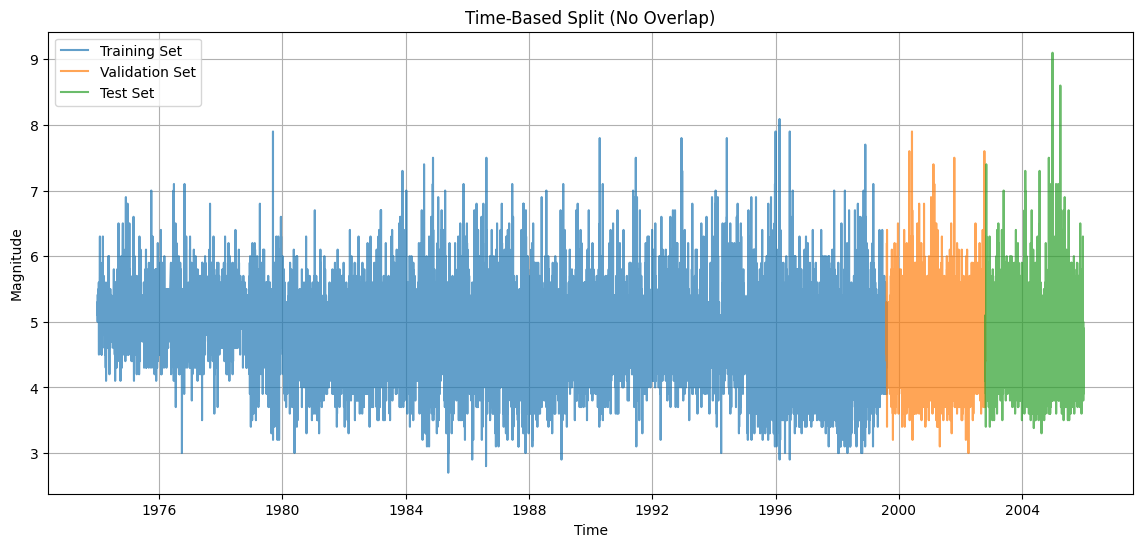

=== RENTANG WAKTU TANPA OVERLAP ===
Train   (20554 data): 1974-01-01 → 1999-08-08
Val     (4024 data):   1999-08-09 → 2002-10-19
Test    (7167 data):  2002-10-20 → 2005-12-31


In [22]:
import pandas as pd
import matplotlib.pyplot as plt

# =============================
# 1. Pastikan datetime format benar
# =============================
df['datetime_combined'] = pd.to_datetime(df['datetime_combined'])
df = df.sort_values(by='datetime_combined').reset_index(drop=True)

# =============================
# 2. Split berdasarkan WAKTU (No Data Leakage)
# =============================
min_t = df['datetime_combined'].min()
max_t = df['datetime_combined'].max()
total_range = max_t - min_t

train_cut = min_t + total_range * 0.80
val_cut   = min_t + total_range * 0.90

train = df[df['datetime_combined'] <= train_cut]
val   = df[(df['datetime_combined'] > train_cut) & (df['datetime_combined'] <= val_cut)]
test  = df[df['datetime_combined'] > val_cut]

# =============================
# 3. Plot data
# =============================
plt.figure(figsize=(14,6))
plt.plot(train['datetime_combined'], train['mag'], label='Training Set', alpha=0.7)
plt.plot(val['datetime_combined'], val['mag'], label='Validation Set', alpha=0.7)
plt.plot(test['datetime_combined'], test['mag'], label='Test Set', alpha=0.7)

plt.legend()
plt.xlabel("Time")
plt.ylabel("Magnitude")
plt.title("Time-Based Split (No Overlap)")
plt.grid(True)
plt.show()

# =============================
# 4. Print Rentang Waktu
# =============================
print("=== RENTANG WAKTU TANPA OVERLAP ===")
print(f"Train   ({len(train)} data): {train['datetime_combined'].min().date()} → {train['datetime_combined'].max().date()}")
print(f"Val     ({len(val)} data):   {val['datetime_combined'].min().date()} → {val['datetime_combined'].max().date()}")
print(f"Test    ({len(test)} data):  {test['datetime_combined'].min().date()} → {test['datetime_combined'].max().date()}")


# **ANN Model Prediction**

Epoch 1/10


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/dense.py:93: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 5ms/step - loss: 1.7835 - val_loss: 0.0416
Epoch 2/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 0.0559 - val_loss: 0.0399
Epoch 3/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0525 - val_loss: 0.0410
Epoch 4/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 4s 5ms/step - loss: 0.0506 - val_loss: 0.0402
Epoch 5/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 4s 3ms/step - loss: 0.0471 - val_loss: 0.0566
Epoch 6/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0486 - val_loss: 0.0338
Epoch 7/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0453 - val_loss: 0.0367
Epoch 8/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0436 - val_loss: 0.0313
Epoch 9/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0438 - val_loss: 0.0314
Epoch 10/10
794/794 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 0.0418 - val_loss: 0.0380
794/794 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
50/50 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
149/149 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step

--- Training (30 Hari) ---
R

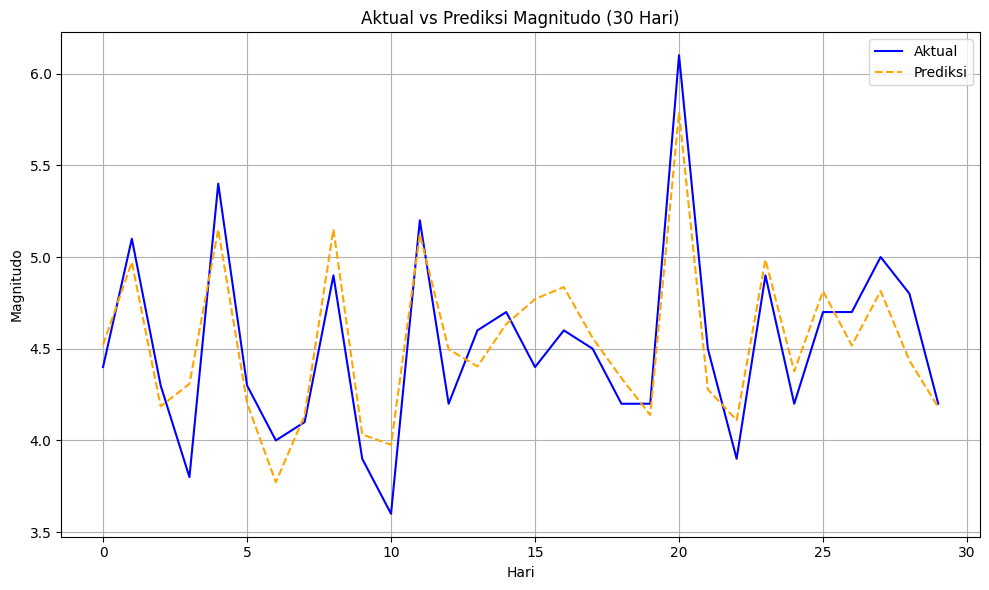

In [23]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score, f1_score, recall_score, precision_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt

# =========================================
# 1. Definisikan Fitur dan Target
# =========================================
target_col = 'mag'

# Kolom yang dikecualikan
exclude_cols = ['mag', 'datetime_combined', 'timestamp_dt', 'timestamp', 'date', 'time', 'place', 'mb']

# Ambil semua kolom numerik kecuali target
feature_cols = [col for col in df.columns if col not in exclude_cols]
feature_cols = df[feature_cols].select_dtypes(include=[np.number]).columns.tolist()

X = df[feature_cols].values
y = df[target_col].values

# =========================================
# 2. Split Data sesuai urutan waktu
# =========================================
n = len(df)
n_train = int(n * 0.80)
n_val   = int(n * 0.05)
n_test  = n - n_train - n_val

X_train = X[:n_train]
y_train = y[:n_train]

X_val = X[n_train:n_train+n_val]
y_val = y[n_train:n_train+n_val]

X_test = X[n_train+n_val:]
y_test = y[n_train+n_val:]

# =========================================
# 3. Normalisasi Data
# =========================================
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# =========================================
# 4. Model ANN
# =========================================
model = Sequential([
    Dense(128, activation='relu', input_shape=(X_train_scaled.shape[1],)),
    Dense(64, activation='relu'),
    Dense(32, activation='relu'),
    Dense(1)
])
model.compile(optimizer='adam', loss='mean_squared_error')

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# =========================================
# 5. Training Model
# =========================================
history = model.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=10,
    batch_size=32,
    callbacks=[early_stopping],
    verbose=1
)

# =========================================
# 6. Prediksi
# =========================================
y_train_pred = model.predict(X_train_scaled)
y_val_pred = model.predict(X_val_scaled)
y_test_pred = model.predict(X_test_scaled)

# =========================================
# 7. Fungsi Evaluasi Lengkap
# =========================================
def evaluate_all(y_true, y_pred, label, threshold=5):
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae = mean_absolute_error(y_true, y_pred)
    r2 = r2_score(y_true, y_pred)

    y_true_class = (y_true >= threshold).astype(int)
    y_pred_class = (y_pred >= threshold).astype(int)
    acc = accuracy_score(y_true_class, y_pred_class)
    f1 = f1_score(y_true_class, y_pred_class)
    recall = recall_score(y_true_class, y_pred_class)
    precision = precision_score(y_true_class, y_pred_class)

    print(f"\n--- {label} ---")
    print(f"RMSE       : {rmse:.4f}")
    print(f"MAE        : {mae:.4f}")
    print(f"R²         : {r2:.4f}")

# =========================================
# 8. Evaluasi Semua Fase
# =========================================
def evaluate_phase(y_true, y_pred, phase):
    evaluate_all(y_true[:30], y_pred[:30], f"{phase} (30 Hari)")

# Jalankan evaluasi
evaluate_phase(y_train, y_train_pred, "Training")
evaluate_phase(y_val, y_val_pred, "Validation")
evaluate_phase(y_test, y_test_pred, "Testing")

# =========================================
# 9. Visualisasi Hasil Prediksi (30 Hari)
# =========================================
plt.figure(figsize=(10,6))
plt.plot(y_test[:30], label='Aktual', color='blue')
plt.plot(y_test_pred[:30], label='Prediksi', color='orange', linestyle='--')
plt.title('Aktual vs Prediksi Magnitudo (30 Hari)')
plt.xlabel('Hari')
plt.ylabel('Magnitudo')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
